# Deep Learning & Art: Neural Style Transfer

This Project uses Neural Style Transfer, an algorithm created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

**Project Objectives:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using the algorithm 
- Define the style cost function for Neural Style Transfer
- Define the content cost function for Neural Style Transfer

Most optimization algorithms usually optimize a cost function to get a set of parameter values. With Neural Style Transfer, it optimizes a cost function to get pixel values.

Basically, Neural Style Transfer uses two images (style and content). It copies the style from the style image and applys it to the content image. 

## Table of Contents

- [1 - Packages](#1)
- [2 - Problem Statement](#2)
- [3 - Transfer Learning](#3)
- [4 - Neural Style Transfer (NST)](#4)
    - [4.1 - Computing the Content Cost](#4-1)
        - [4.1.1 - Make Generated Image G Match the Content of Image C](#4-1-1)
        - [4.1.2 - Content Cost Function  𝐽𝑐𝑜𝑛𝑡𝑒𝑛𝑡(𝐶,𝐺)](#4-1-2)
            - [compute_content_cost](#-)
    - [4.2 - Computing the Style Cost](#4-2)
        - [4.2.1 - Style Matrix](#4-2-1)
            - [gram_matrix](#-)
        - [4.2.2 - Style Cost](#4-2-2)
            - [compute_layer_style_cost](#-)
        - [4.2.3 Style Weights](#4-2-3)
            - [compute_style_cost](#-)
    - [4.3 - Defining the Total Cost to Optimize](#4-3)
        - [total_cost](#-)
- [5 - Solving the Optimization Problem](#5)
    - [5.1 Load the Content Image](#5-1)
    - [5.2 Load the Style Image](#5-2)
    - [5.3 Randomly Initialize the Image to be Generated](#5-3)
    - [5.4 - Load Pre-trained VGG19 Model](#5-4)
    - [5.5 - Compute Total Cost](#5-5)
        - [5.5.1 - Compute Content Cost](#5-5-1)
        - [5.5.2 - Compute Style Cost](#5-5-2)
            - [train_step](#-)
    - [5.6 - Train the Model](#5-6)
- [6 - References](#6)




<a name='1'></a>
## 1 - Packages

importing the necessary packages and dependencies needed to perform Neural Style Transfer.

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

<a name='2'></a>
## 2 - Problem Statement

Neural Style Transfer (NST) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a <strong>"content" image (C)</strong> and a <strong>"style" image (S)</strong>, to create a <strong>"generated" image (G)</strong>. The generated image G combines the "content" of the image C with the "style" of image S. 

In this project, I am going to combine the Louvre museum in Paris (content image C) with the impressionist style of Claude Monet (content image S) to generate the following image:

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

<a name='3'></a>
## 3 - Transfer Learning


Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

I will be using the eponymously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, I'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers).

* The shallower layers of a ConvNet tend to detect lower-level features such as <i>edges and simple textures</i>.
* The deeper layers tend to detect higher-level features such as more <i> complex textures and object classes</i>. 

In [2]:
# Load parameters from the VGG model.
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<a name='4'></a>
## 4 - Neural Style Transfer (NST)

Next, I'll be building the Neural Style Transfer (NST) algorithm in three steps:

- First, I will build the content cost function $J_{content}(C,G)$
- Second, I will build the style cost function $J_{style}(S,G)$
- Finally, I'll put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

<a name='4-1'></a>
### 4.1 - Computing the Content Cost

<a name='4-1-1'></a>
#### 4.1.1 - Make Generated Image G Match the Content of Image C

An important goal to aim for when performing NST is for the content in generated image G to match the content of image C. 

#### To choose a "middle" activation layer $a^{[l]}$ :
The "generated" image G must have a similar content as the input image C. 
* In practice, the most visually pleasing results is achieved if we choose a layer in the <b>middle</b> of the network--neither too shallow nor too deep. This ensures that the network detects both higher-level and lower-level features.

#### To forward propagate image "C:"
* Set the image C as the input to the pretrained VGG network, and run forward propagation.  
* Let $a^{(C)}$ be the hidden layer activations in the chosen layer. This will be an $n_H \times n_W \times n_C$ tensor.

#### To forward propagate image "G":
* Repeat this process with the image G: Set G as the input, and run forward progation. 
* Let $a^{(G)}$ be the corresponding hidden layer activation. 

In this running example, the content image C will be the picture of the Louvre Museum in Paris. 

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


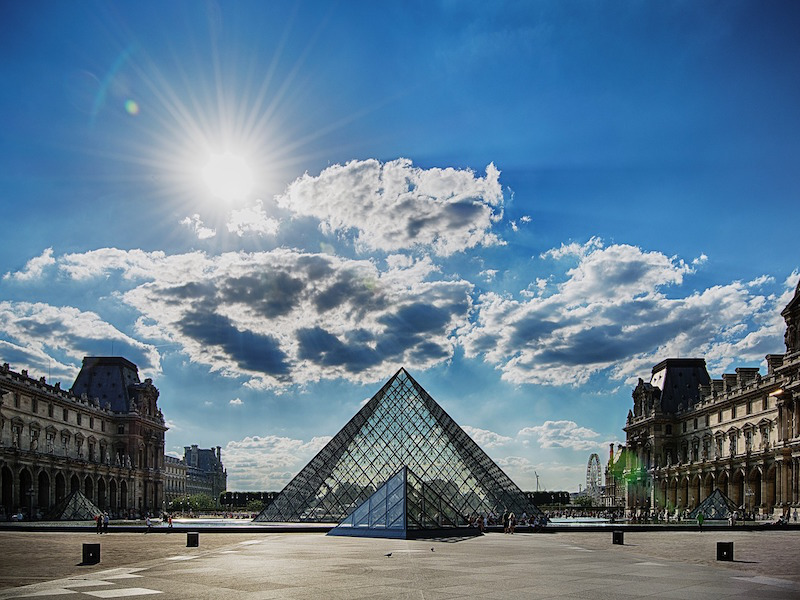

In [3]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='4-1-2'></a>
#### 4.1.2 - Content Cost Function $J_{content}(C,G)$
To achieve the goal of matching generated image G to image C is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the chosen hidden layer, and appear in a normalization term in the cost. 
* Note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* In order to compute the cost $J_{content}(C,G)$, it is convenient to unroll these 3D volumes into a 2D matrix, as shown below.
* Technically this unrolling step isn't needed to compute $J_{content}$, but it is a good practice for carrying out similar operations (later for computing the style cost) $J_{style}$.

<img src="images/NST_LOSS.png" style="width:800px;height:400px;">

<a name='-'></a>
### compute_content_cost

I'll Compute the "content cost" using TensorFlow:

`a_G`: hidden layer activations representing content of the image G
<br>
`a_C`: hidden layer activations representing content of the image C 

In [4]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C]) # used -1 rather than n_H x  n_W
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C]) # used -1 rather than n_H x  n_W
    
    # compute the cost with tensorflow 
    J_content = (1/(4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    return J_content

<br>
<font color = 'blue'>
 
**Final notes on calculating the content cost function!:**
    
- The content cost takes a hidden layer activation of the neural network, and measures how different $a^{(C)}$ and $a^{(G)}$ are. 
- Minimizing the content cost later, will help make sure $G$ has similar content as $C$. 

<a name='4-2'></a>
### 4.2 - Computing the Style Cost

For the running example, I will use the following style image: 

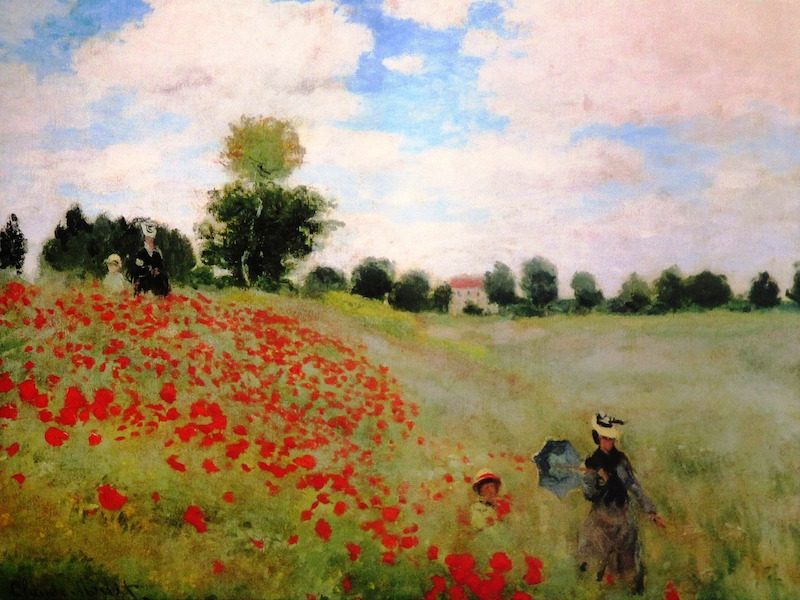

In [6]:
example = Image.open("images/monet_800600.jpg")
example

This was painted in the style of <b>[impressionism](https://en.wikipedia.org/wiki/Impressionism)</b>.

Now I'll define a "style" cost function $J_{style}(S,G)$

<a name='4-2-1'></a>
#### 4.2.1 - Style Matrix

#### Gram matrix
* The style matrix is also called a "Gram matrix." 
* In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. 
* In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, it is expected to have a large dot product, and thus for $G_{ij}$ to be large. 

#### Two meanings of the variable $G$
* Note that there is an  collision in the variable names used. Following the common terminology used in the literature: 
    * $G$ is used to denote the Style matrix (or Gram matrix) 
    * $G$ also denotes the generated image. 
* For the sake of clarity, in this project $G_{gram}$ will be used to refer to the Gram matrix, and $G$ to denote the generated image.

#### Compute Gram matrix $G_{gram}$
I will compute the Style matrix by multiplying the "unrolled" filter matrix with its transpose:

<img src="images/NST_GM.png" style="width:900px;height:300px;">

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$

#### $G_{(gram)ij}$: correlation
The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters (channels). The value $G_{(gram)i,j}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

#### $G_{(gram),ii}$: prevalence of patterns or textures
* The diagonal elements $G_{(gram)ii}$ measure how "active" a filter $i$ is. 
* For example, if filter $i$ is detecting vertical textures in the image. Then $G_{(gram)ii}$ measures how common  vertical textures are in the image as a whole.
* If $G_{(gram)ii}$ is large, this means that the image has a lot of vertical texture. 


By capturing the prevalence of different types of features ($G_{(gram)ii}$), as well as how much different features occur together ($G_{(gram)ij}$), the Style matrix $G_{gram}$ measures the style of an image. 

<a name='-'></a>
### gram_matrix
* I'll use TensorFlow to implement a function that computes the Gram matrix of a matrix A. 
    * The formula is: The gram matrix of A is $G_A = AA^T$.

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A, tf.transpose(A))
    return GA

<a name='4-2-2'></a>
#### 4.2.2 - Style Cost

Next goal will be to minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For starters, I will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* Note: this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$

<a name='-'></a>
###  compute_layer_style_cost
Compute the style cost for a single layer

In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W) 
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C])) # same as(shape=[n_C, n_H * n_W]) but transpose to work
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C])) # same as(shape=[n_C, n_H * n_W]) but transpose to work

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = (1/(4*n_C*n_C*(n_H*n_W)*(n_H*n_W)))*(tf.reduce_sum(tf.square(tf.subtract(GS,GG))))
    return J_style_layer

<a name='4-2-3'></a>
#### 4.2.3 Style Weights

* I've captured the style from only one layer. 
* But I'll get better results if I "merge" style costs from several different layers. 
* Each layer will be given weights ($\lambda^{[l]}$) that reflect how much each layer will contribute to the style.
* By default, each layer will have equal weight, and the weights add up to 1.  ($\sum_{l}^L\lambda^{[l]} = 1$)

Listing the layer names:

In [11]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The output of a layer `block5_conv4`. Will later define this as the content layer, which will represent the image.

In [12]:
vgg.get_layer('block5_conv4').output

<tf.Tensor 'block5_conv4/Relu:0' shape=(None, 25, 25, 512) dtype=float32>

Now, choosing layers to represent the style of the image and assign style costs:

In [13]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

I'll combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 

<a name='-'></a>
### compute_style_cost
Compute style cost: 
* It calls `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. 

#### Description of `compute_style_cost`
For each layer:
* Select the activation (the output tensor) of the current layer.
* Get the style of the style image "S" from the current layer.
* Get the style of the generated image "G" from the current layer.
* Compute the "style cost" for the current layer
* Add the weighted style cost to the overall style cost (J_style) 
* Return the overall style cost.

In [14]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

Note for choosing the coefficients for each layer:
The deeper layers capture higher-level concepts, and the features in the deeper layers are less localized in the image relative to each other. So if I wanted the generated image to softly follow the style image, I will choose larger weights for deeper layers and smaller weights for the first layers. In contrast, if I want the generated image to strongly follow the style image, I'll choose smaller weights for deeper layers and larger weights for the first layers.



<br>
<font color = 'blue'>
    
**Key notes:**
    
- The style of an image can be represented using the Gram matrix of a hidden layer's activations. 
- The results become better by combining this representation from multiple different layers. 
- This is in contrast to the content representation, where usually using just a single hidden layer is sufficient.
- Minimizing the style cost will cause the image $G$ to follow the style of the image $S$. 

<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

Finally, I will create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

<a name='-'></a>
### total_cost

Implementing the total cost function which includes both the content cost and the style cost:

In [15]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style

    return J

<font color = 'blue'>
    
**Key notes:**
- The total cost is a linear combination of the content cost $J_{content}(C,G)$ and the style cost $J_{style}(S,G)$.
- $\alpha$ and $\beta$ are hyperparameters that control the relative weighting between content and style.

<a name='5'></a>
## 5 - Solving the Optimization Problem

Finally, I'll put everything together to implement Neural Style Transfer!


The program will be able to do the follwing:

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

<a id='part(4)'></a>

<a name='5-1'></a>
### 5.1 Load the Content Image
Load, reshape, and normalize the "content" image C (the Louvre museum picture):

(1, 400, 400, 3)


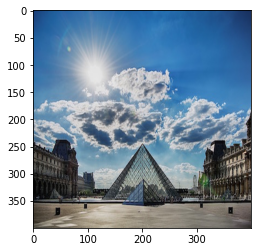

In [17]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image
Load, reshape and normalize your "style" image (Claude Monet's painting):

(1, 400, 400, 3)


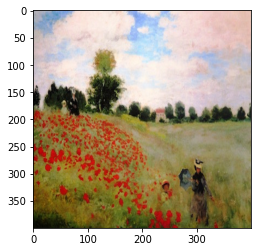

In [18]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Randomly Initialize the Image to be Generated
Initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

(1, 400, 400, 3)


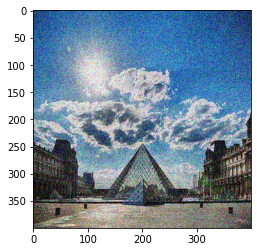

In [19]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model
A function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [20]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Define the content layer and build the model.

In [21]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [22]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

<a name='5-5'></a>
### 5.5 - Compute Total Cost

<a name='5-5-1'></a>
#### 5.5.1 - Compute the Content image Encoding (a_C)

after building the model, I will compute the content cost. I will encode the content image using the appropriate hidden layer activations and set this encoding to the variable `a_C`. I will use layer `block5_conv4` to compute the encoding. The code below does the following:

1. Set a_C to be the tensor giving the hidden layer activation for layer "block5_conv4" using the content image.

In [23]:
# Assign the content image to be the input of the VGG model.  
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### 5.5.2 - Compute the Style image Encoding (a_S) 

Setting a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using the style image.

In [24]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils needed to display the images generated by the style transfer model.

In [25]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='-'></a>
### train_step 

The train_step() function is for transfer learning with the follwing details:
* Use the Adam optimizer to minimize the total cost `J`.
* Use a learning rate of 0.01  
* Within the tf.GradientTape():
   * Compute the encoding of the generated image using vgg_model_outputs. Assign the result to a_G.
   * Compute the total cost J, using the global variables a_C, a_S and the local a_G
   * Use `alpha = 10` and `beta = 40`.

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # using the precomputed encoded images a_S and a_C In this function
        # Compute a_G as the vgg_model_outputs for the current generated image
        
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)

        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

Now I'll get to put it all together into one function to better see the results!

<a name='5-6'></a>
### 5.6 - Train the Model

Generate an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If I increased the learning rate it can speed up the style transfer, but often at the cost of quality.

Epoch 0 


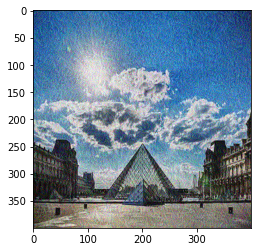

Epoch 250 


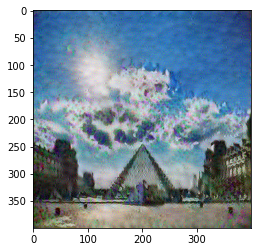

Epoch 500 


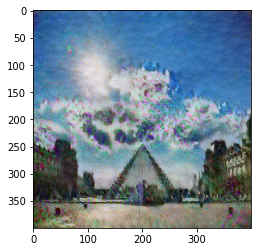

Epoch 750 


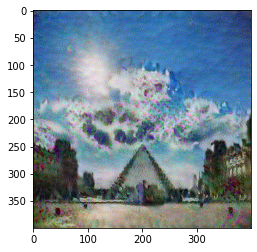

Epoch 1000 


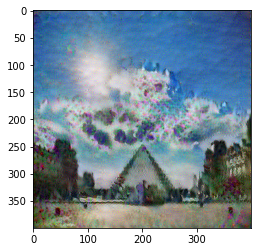

Epoch 1250 


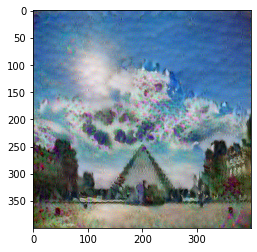

Epoch 1500 


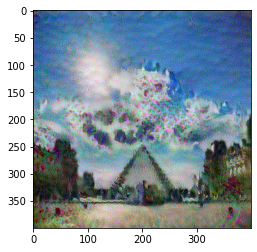

Epoch 1750 


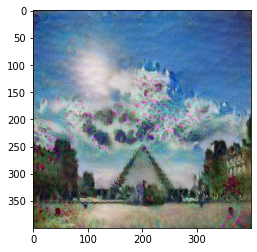

Epoch 2000 


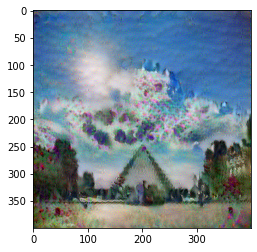

Epoch 2250 


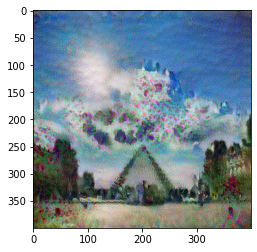

Epoch 2500 


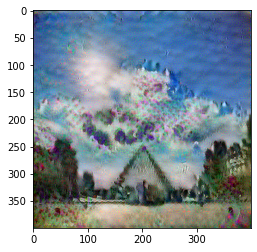

In [30]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

See the results!

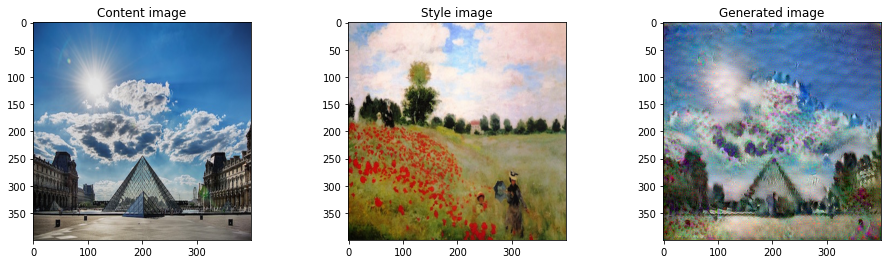

In [31]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

Running for around 20000 epochs with a learning rate of 0.001, you should see something like the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

The hyperparameters were set so that there is no need to wait too long to see an initial result. To get the best looking results, try running the optimization algorithm longer (and perhaps with a smaller learning rate).

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

### Conclusion

I've used Neural Style Transfer to generate artistic images, a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. 
<font color = 'blue'>
    
## Final Notes
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 

<a name='6'></a>
## 6 - References

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups this lab was inspired by. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, [Convolutional neural networks for artistic style transfer.](https://harishnarayanan.org/writing/artistic-style-transfer/)
- Log0, [TensorFlow Implementation of "A Neural Algorithm of Artistic Style".](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)
- Karen Simonyan and Andrew Zisserman (2015). [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf)
- [MatConvNet.](http://www.vlfeat.org/matconvnet/pretrained/)


In [1]:
!jupyter nbconvert --execute --to markdown Art_Generation_with_Neural_Style_Transfer.ipynb

[NbConvertApp] Converting notebook Art_Generation_with_Neural_Style_Transfer.ipynb to markdown
2022-09-17 09:49:12.186534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-09-17 09:49:12.186927: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-17 09:49:20.555947: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-09-17 09:49:20.556261: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 09:49:20.562458: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: MSI
2022-09-17 09:49:20.562617: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: MSI
2022-09-17 09:49:20.564961: I tenso